# Sex-classifications using FreeSurfer Volumetric Features - XGBoost

- Stratified 5-fold cross-validation with grid search for hyperparameter tuning
- Accuracy, confusion matrix, and feature importance analysis

In [1]:
import sys
sys.path.append("../Modules")
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from ml_utils import get_folds

In [2]:
# Load the data and add Sex and Scanner columns
data = pd.read_excel("../Data/volumetry_cc359.xlsx") # Reading the excel file
data.columns = data.columns.str.replace('[^A-Za-z0-9]+', '_').str.strip('_') #Replacing all the special characters and spaces in column name with underscore
data.dropna(axis=1, how='all', inplace=True) # Drops the NA values from the dataframe
data["Sex"] = data["Measure_volume"].apply(lambda x: x.split("_")[-1]) #Adding a new column to the dataframe called 'Sex' which identifies the gender.
data["Scanner"] = data["Measure_volume"].apply(lambda x: x.split("_")[1]) #Extracting Scanner from Measure_volume column and add it as a new column
data.head()

c:\Users\rober\anaconda3\envs\xgboost\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


,Measure_volume,Left_Lateral_Ventricle,Left_Inf_Lat_Vent,Left_Cerebellum_White_Matter,Left_Cerebellum_Cortex,Left_Thalamus,Left_Caudate,Left_Putamen,Left_Pallidum,3rd_Ventricle,...,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness,BrainSegVolNotVent_2,eTIV_1,Age,Sex,Scanner
0,CC0001_philips_15_55_M,14383.5,347.3,16704.9,65545.9,8355.0,3695.2,5246.1,2100.0,1751.2,...,2.691,3.194,2.485,2.897,2.48085,1266382,1.756431e+06,55,M,philips
1,CC0002_philips_15_56_M,5369.2,162.8,12668.8,53370.0,7143.5,3139.9,4500.7,1901.5,664.8,...,2.498,3.253,2.137,2.720,2.30978,1023139,1.393890e+06,56,M,philips
2,CC0003_philips_15_63_F,3029.2,175.6,9510.2,39296.2,6056.8,2646.2,4096.1,1384.8,712.3,...,2.619,3.334,2.248,2.671,2.34480,867254,1.259727e+06,63,F,philips
3,CC0004_philips_15_67_M,8787.8,335.3,15830.3,53213.8,8423.4,3557.6,4689.5,2025.5,1689.7,...,2.746,3.519,2.560,2.786,2.39372,1255855,1.805187e+06,67,M,philips
4,CC0005_philips_15_62_M,8025.8,363.9,12819.5,55662.0,8333.7,3367.5,3873.6,2021.2,743.3,...,2.712,3.652,2.647,3.060,2.56043,1119780,1.651331e+06,62,M,philips


c:\Users\rober\anaconda3\envs\xgboost\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


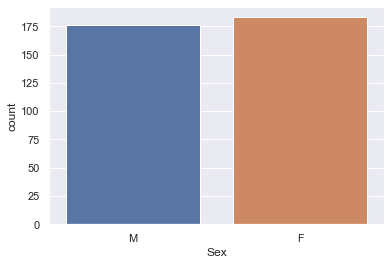

In [3]:
sns.set(style="darkgrid")
ax = sns.countplot(data["Sex"]) #plotting the Sex distribution from the DataFrame

c:\Users\rober\anaconda3\envs\xgboost\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


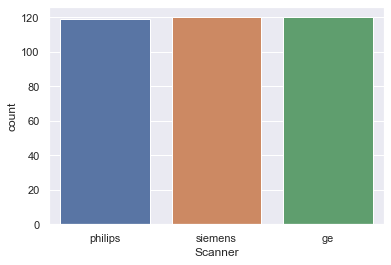

In [4]:
sns.set(style="darkgrid")
ax = sns.countplot(data["Scanner"]) #plotting the Scanner distribution from the DataFrame

In [5]:
#replaces the gender by 0/1, 0 for Female and 1 for Male
data.loc[data['Sex'] == "F", 'Sex'] = 0 
data.loc[data['Sex'] == "M", 'Sex'] = 1
data["Sex"] = data["Sex"].astype(int)
#replaces the scanner vendor by 0, 1, 2
data.loc[data['Scanner'] == "philips", 'Scanner'] = 0 
data.loc[data['Scanner'] == "siemens", 'Scanner'] = 1
data.loc[data['Scanner'] == "ge", 'Scanner'] = 1
data["Scanner"] = data["Scanner"].astype(int)
data.head()

,Measure_volume,Left_Lateral_Ventricle,Left_Inf_Lat_Vent,Left_Cerebellum_White_Matter,Left_Cerebellum_Cortex,Left_Thalamus,Left_Caudate,Left_Putamen,Left_Pallidum,3rd_Ventricle,...,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness,BrainSegVolNotVent_2,eTIV_1,Age,Sex,Scanner
0,CC0001_philips_15_55_M,14383.5,347.3,16704.9,65545.9,8355.0,3695.2,5246.1,2100.0,1751.2,...,2.691,3.194,2.485,2.897,2.48085,1266382,1.756431e+06,55,1,0
1,CC0002_philips_15_56_M,5369.2,162.8,12668.8,53370.0,7143.5,3139.9,4500.7,1901.5,664.8,...,2.498,3.253,2.137,2.720,2.30978,1023139,1.393890e+06,56,1,0
2,CC0003_philips_15_63_F,3029.2,175.6,9510.2,39296.2,6056.8,2646.2,4096.1,1384.8,712.3,...,2.619,3.334,2.248,2.671,2.34480,867254,1.259727e+06,63,0,0
3,CC0004_philips_15_67_M,8787.8,335.3,15830.3,53213.8,8423.4,3557.6,4689.5,2025.5,1689.7,...,2.746,3.519,2.560,2.786,2.39372,1255855,1.805187e+06,67,1,0
4,CC0005_philips_15_62_M,8025.8,363.9,12819.5,55662.0,8333.7,3367.5,3873.6,2021.2,743.3,...,2.712,3.652,2.647,3.060,2.56043,1119780,1.651331e+06,62,1,0


In [6]:
#Printing all the column names to have a look at the oveall features we have
for col_name in data.columns:
    print(col_name, end =",")

Measure_volume,Left_Lateral_Ventricle,Left_Inf_Lat_Vent,Left_Cerebellum_White_Matter,Left_Cerebellum_Cortex,Left_Thalamus,Left_Caudate,Left_Putamen,Left_Pallidum,3rd_Ventricle,4th_Ventricle,Brain_Stem,Left_Hippocampus,Left_Amygdala,CSF,Left_Accumbens_area,Left_VentralDC,Left_vessel,Left_choroid_plexus,Right_Lateral_Ventricle,Right_Inf_Lat_Vent,Right_Cerebellum_White_Matter,Right_Cerebellum_Cortex,Right_Thalamus,Right_Caudate,Right_Putamen,Right_Pallidum,Right_Hippocampus,Right_Amygdala,Right_Accumbens_area,Right_VentralDC,Right_vessel,Right_choroid_plexus,5th_Ventricle,WM_hypointensities,Left_WM_hypointensities,Right_WM_hypointensities,non_WM_hypointensities,Left_non_WM_hypointensities,Right_non_WM_hypointensities,Optic_Chiasm,CC_Posterior,CC_Mid_Posterior,CC_Central,CC_Mid_Anterior,CC_Anterior,BrainSegVol,BrainSegVolNotVent,lhCortexVol,rhCortexVol,CortexVol,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,SupraTento

c:\Users\rober\anaconda3\envs\xgboost\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


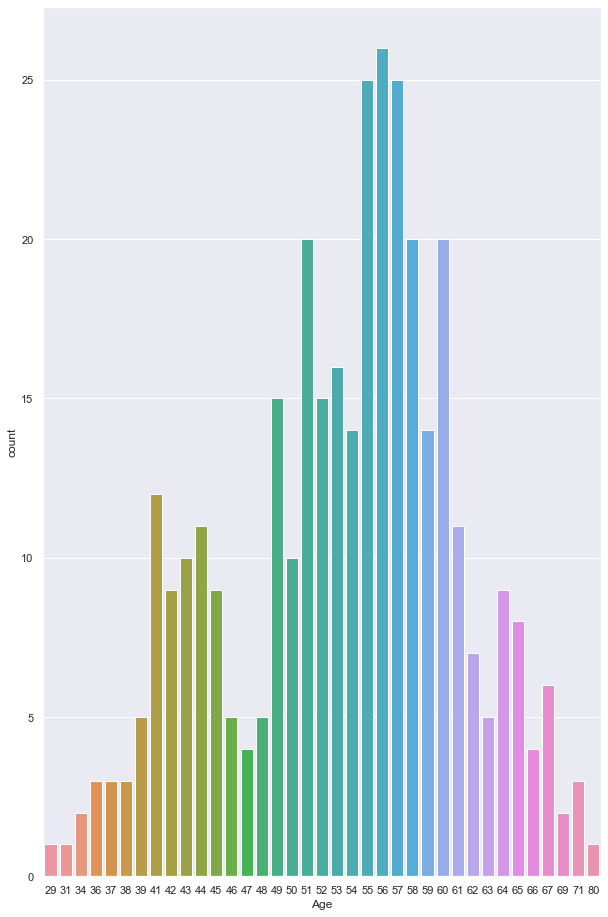

In [7]:
fig, ax = plt.subplots(figsize=(10,16))
sns.set(style="darkgrid")
ax = sns.countplot(data["Age"]) #plotting the Scanner distribution from the DataFrame

In [8]:
test_split = glob.glob("../Data/CC359-data-split/5-fold-CV-stratified/test*.txt")
to_drop = ['Measure_volume', 'Scanner', "Sex", "eTIV", "Scanner", "BrainSegVolNotVent_2","eTIV_1", "BrainSegVolNotVent", "BrainSegVolNotVent_1", "MaskVol"]
to_keep = ["Sex"]

folds = get_folds(data,test_split, to_drop, to_keep)
print(type(folds))

<class 'generator'>


In [9]:
test_sets_accuracy = []
confusion = np.zeros((2,2))
importances = []

# Random Forest Grid Search
param_grid = {
              'objective':['binary:logistic'],
              'learning_rate': [0.1, 0.05],
              'max_depth': [12, 14, 16, 18],
              'subsample': [0.8, 0.7],
              'num_rounds': [1000,1500],
              'nthread': [6]}



#Iterating through each test set
for (Xtrain,Ytrain,Xtest,Ytest) in folds:
    
    scaler = StandardScaler()
    scaler.fit(Xtrain)
    Xtrain_scaled = scaler.transform(Xtrain)
    Xtest_scaled = scaler.transform(Xtest)
    print(Xtrain.shape)
    base_estimator = xgb.XGBClassifier()
    
    #Defining GridSearch with different parameters
    clf = GridSearchCV(base_estimator, param_grid=param_grid, n_jobs=6, cv = 4, scoring='accuracy', verbose=2, refit=True)
    clf.fit(Xtrain_scaled, Ytrain["Sex"]) 
    print(clf.best_params_) #Printing the best parameters
    Ypred = clf.predict(Xtest_scaled) #Predicting labels for test data
    accuracy = accuracy_score(Ytest, Ypred) #Calculating accuracy
    test_sets_accuracy.append(accuracy * 100.0) #Multiplying accuracy with 100 to get percentage value
    confusion+=(confusion_matrix(Ytest, Ypred))
    importances.append(clf.best_estimator_.feature_importances_)

(287, 133)
Fitting 4 folds for each of 32 candidates, totalling 128 fits


c:\Users\rober\anaconda3\envs\xgboost\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:23] WARNING: ..\src\learner.cc:576: 
Parameters: { "num_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:21:23] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'learning_rate': 0.1, 'max_depth': 12, 'nthread': 6, 'num_rounds': 1000, 'objective': 'binary:logistic', 'subsample': 0.8}
(287, 133)
Fitting 4 folds for each of 32 candidates, totalling 128 fits


c:\Users\rober\anaconda3\envs\xgboost\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:26] WARNING: ..\src\learner.cc:576: 
Parameters: { "num_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:21:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'learning_rate': 0.05, 'max_depth': 12, 'nthread': 6, 'num_rounds': 1000, 'objective': 'binary:logistic', 'subsample': 0.7}
(287, 133)
Fitting 4 folds for each of 32 candidates, totalling 128 fits


c:\Users\rober\anaconda3\envs\xgboost\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:30] WARNING: ..\src\learner.cc:576: 
Parameters: { "num_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:21:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'learning_rate': 0.1, 'max_depth': 12, 'nthread': 6, 'num_rounds': 1000, 'objective': 'binary:logistic', 'subsample': 0.8}
(287, 133)
Fitting 4 folds for each of 32 candidates, totalling 128 fits


c:\Users\rober\anaconda3\envs\xgboost\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:21:34] WARNING: ..\src\learner.cc:576: 
Parameters: { "num_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:21:34] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'learning_rate': 0.05, 'max_depth': 12, 'nthread': 6, 'num_rounds': 1000, 'objective': 'binary:logistic', 'subsample': 0.7}
(288, 133)
Fitting 4 folds for each of 32 candidates, totalling 128 fits
[11:21:37] WARNING: ..\src\learner.cc:576: 
Parameters: { "num_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then

c:\Users\rober\anaconda3\envs\xgboost\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [10]:
print("Accuracy Achieved (mean +/- std): ", np.mean(test_sets_accuracy),np.std(test_sets_accuracy))

Accuracy Achieved (mean +/- std):  80.23082942097028 3.5179867759198915


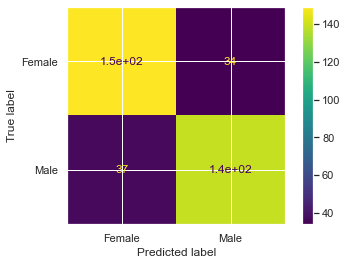

In [11]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion,
                               display_labels=['Female', 'Male'])
disp.plot()
plt.show()

<Figure size 4608x4608 with 0 Axes>

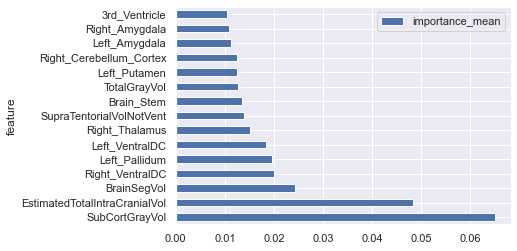

In [12]:
fi_mean = np.array(importances).mean(axis = 0)
fi_std = np.array(importances).std(axis = 0)

fi = pd.DataFrame({"feature":Xtrain.columns, "importance_mean":fi_mean, "importance_std":fi_std})
plt.figure(figsize = (64,64))
ax = fi.sort_values('importance_mean', ascending=False)[:15].plot.barh(x = 'feature', y='importance_mean', rot=0)

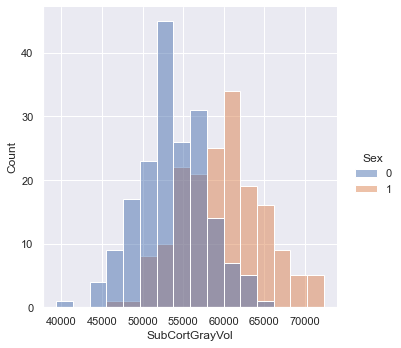

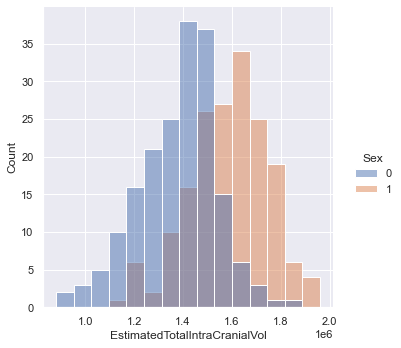

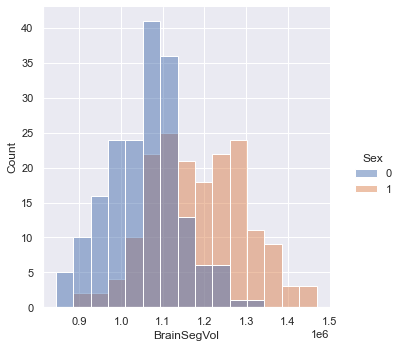

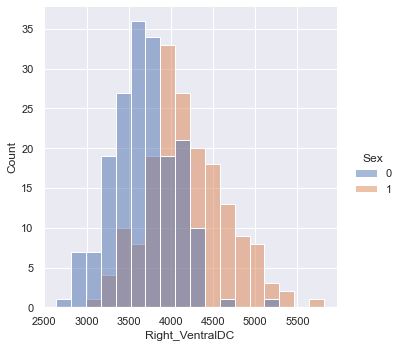

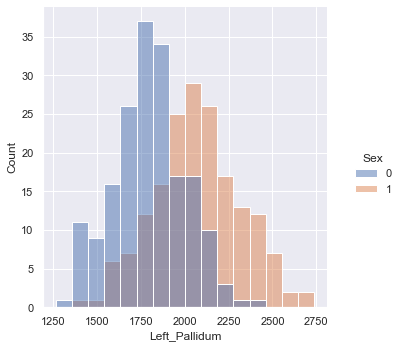

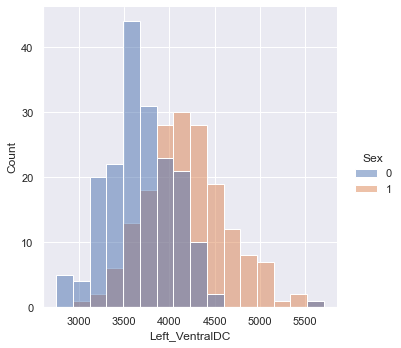

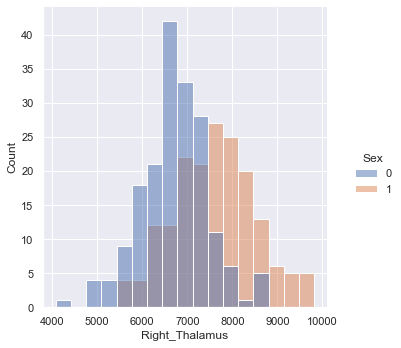

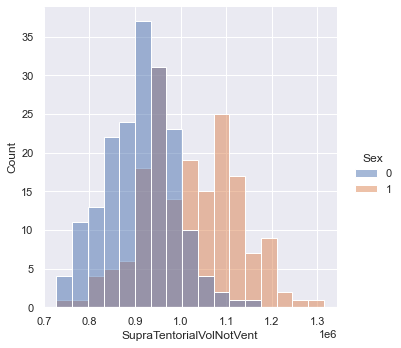

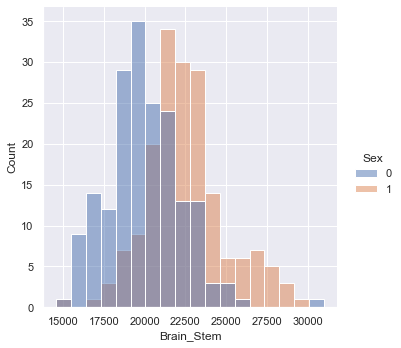

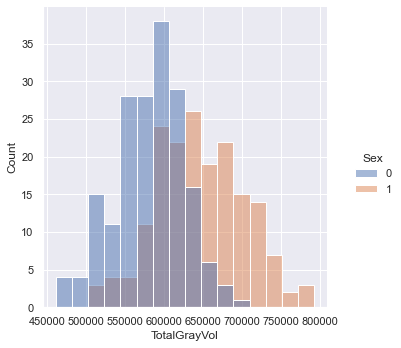

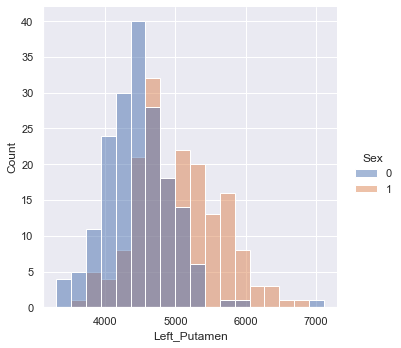

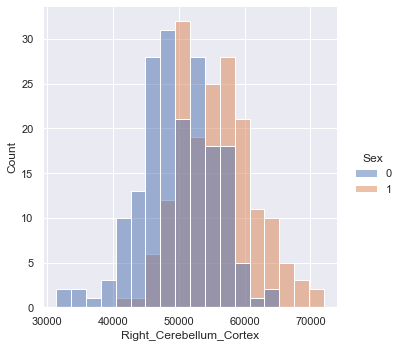

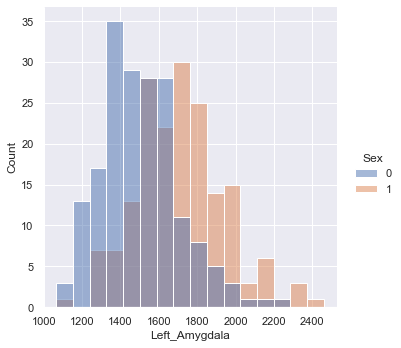

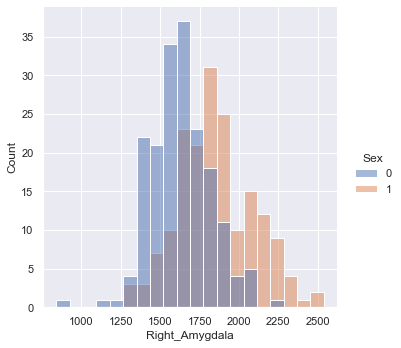

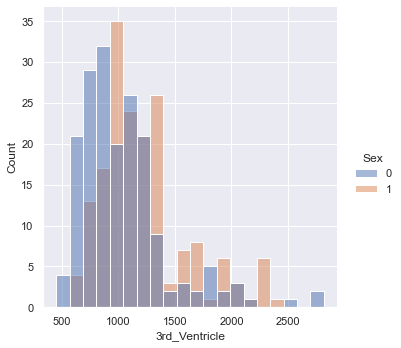

In [13]:
for feature in fi.sort_values('importance_mean', ascending=False)[:15]["feature"]:
    sns.set_theme(style="darkgrid")
    sns.displot(data, x=feature, hue="Sex")